In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [82]:
nside = 256
npix = hp.nside2npix(nside)

sky_south = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_{}_south.fits'.format(nside)))
sky_south['PHOTSYS'] = 'S'
sky_north = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/sky_resid_map_{}_north.fits'.format(nside)))
sky_north['PHOTSYS'] = 'N'

mask = (sky_north['DEC']>32.375)
sky_north = sky_north[mask]
mask = ~np.in1d(sky_south['HPXPIXEL'], sky_north['HPXPIXEL'])
sky = vstack([sky_north, sky_south[mask]])

In [83]:
nsource_min = 250 * (512/nside)**2
mask = sky['nsource_g']>nsource_min
mask &= sky['nsource_r']>nsource_min
mask &= sky['nsource_z']>nsource_min
print(np.sum(mask)/len(mask))
sky = sky[mask]

0.9598767699748423


In [5]:
# mask = sky['PHOTSYS']=='S'
# sky = sky[mask]

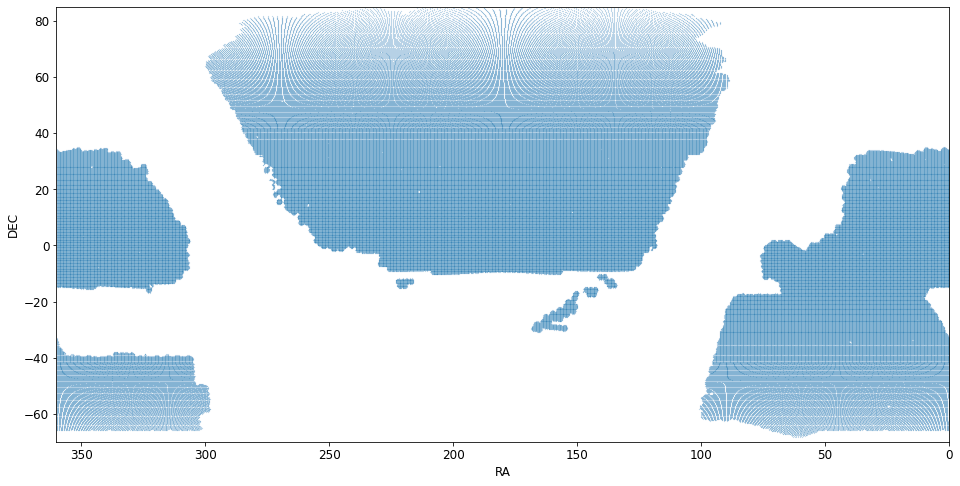

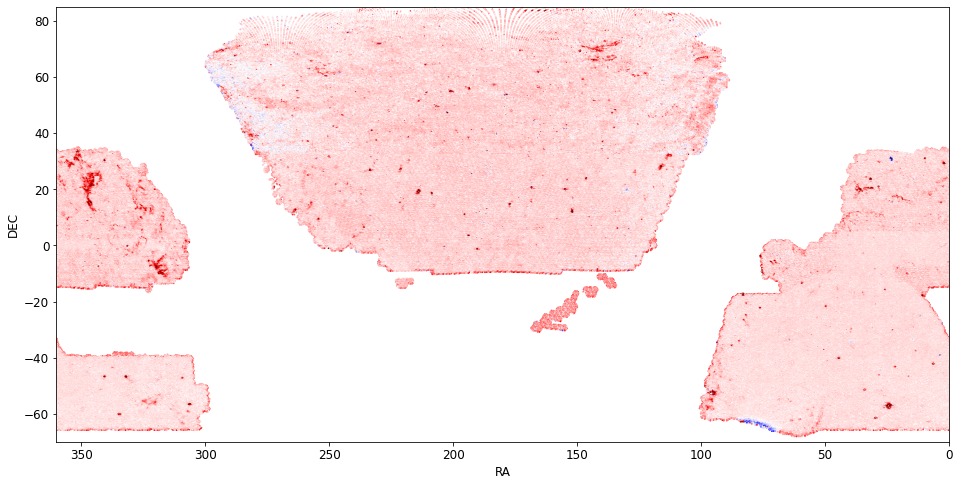

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(sky['RA'], sky['DEC'], '.', ms=0.2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'], sky['DEC'], c=sky['sky_median_g'], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [7]:
nside = 256
min_nobs = 1
maskbits = []
# custom_mask_name = 'lrgmask_v1.1'
custom_mask_name = 'elgmask_v1'

min_pix_frac = 0.5  # minimum fraction of pixel area to be used

mask_str = ''.join([str(tmp) for tmp in maskbits])
if custom_mask_name!='':
    mask_str += '_' + custom_mask_name

randoms_counts_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/randoms_stats/0.49.0/resolve/counts'
randoms_systematics_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/randoms_stats/0.49.0/resolve/systematics'

npix = hp.nside2npix(nside)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)

maps = Table.read(os.path.join(randoms_counts_dir, 'counts_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format('north', nside, min_nobs, mask_str)))
maps['PHOTSYS'] = 'N'
maps = maps[maps['n_randoms']>0]
maps1 = Table.read(os.path.join(randoms_systematics_dir, 'systematics_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format('north', nside, min_nobs, mask_str)))
maps1.remove_columns(['RA', 'DEC'])
maps = join(maps, maps1, join_type='inner', keys='HPXPIXEL')
maps_north = maps.copy()

maps = Table.read(os.path.join(randoms_counts_dir, 'counts_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format('south', nside, min_nobs, mask_str)))
maps['PHOTSYS'] = 'S'
maps = maps[maps['n_randoms']>0]
maps1 = Table.read(os.path.join(randoms_systematics_dir, 'systematics_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format('south', nside, min_nobs, mask_str)))
maps1.remove_columns(['RA', 'DEC'])
maps = join(maps, maps1, join_type='inner', keys='HPXPIXEL')
maps_south = maps.copy()

mask = (maps_north['DEC']>32.375)
maps_north = maps_north[mask]

mask = ~np.in1d(maps_south['HPXPIXEL'], maps_north['HPXPIXEL'])
maps = vstack([maps_north, maps_south[mask]])

print(len(maps))

area = np.sum(maps['FRACAREA'])*pix_area
print('Area = {:.1f} sq deg'.format(area))

mask = maps['FRACAREA']>min_pix_frac
maps = maps[mask]

# mask = maps['PHOTSYS']=='S'
# maps = maps[mask]

381227
Area = 17027.1 sq deg


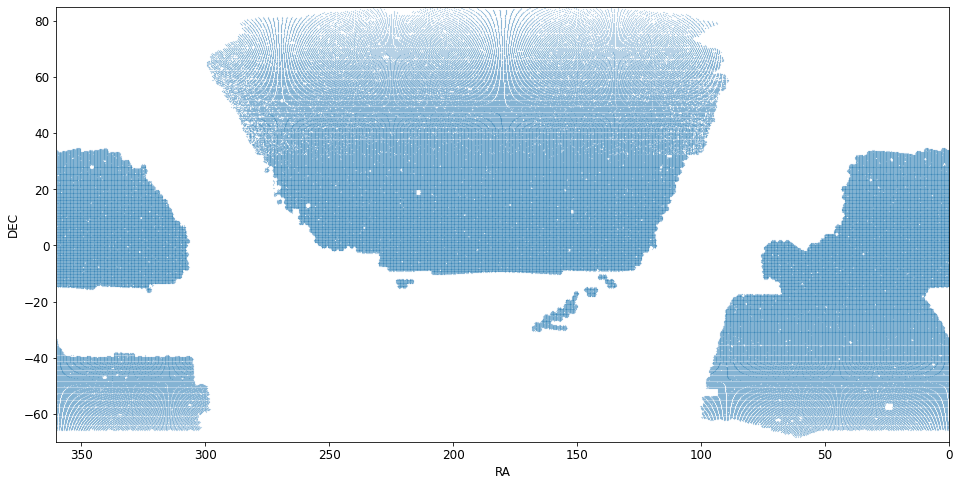

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(maps['RA'], maps['DEC'], '.', ms=0.2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [9]:
sys_columns = ['HPXPIXEL', 'EBV', 'galdepth_gmag', 'galdepth_rmag', 'galdepth_zmag', 'psfdepth_gmag', 'psfdepth_rmag', 'psfdepth_zmag', 'psfdepth_w1mag', 'psfdepth_w2mag', 'galdepth_gmag_ebv', 'galdepth_rmag_ebv', 'galdepth_zmag_ebv', 'psfdepth_gmag_ebv', 'psfdepth_rmag_ebv', 'psfdepth_zmag_ebv', 'psfdepth_w1mag_ebv', 'psfdepth_w2mag_ebv', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z']
maps = maps[sys_columns]

print(len(sky))
sky = join(sky, maps, join_type='inner')
print(len(sky))

380629
366399


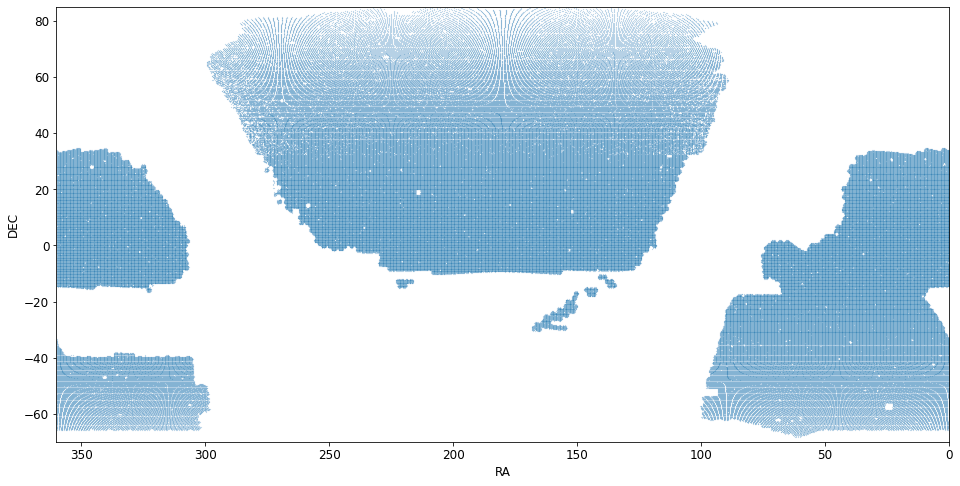

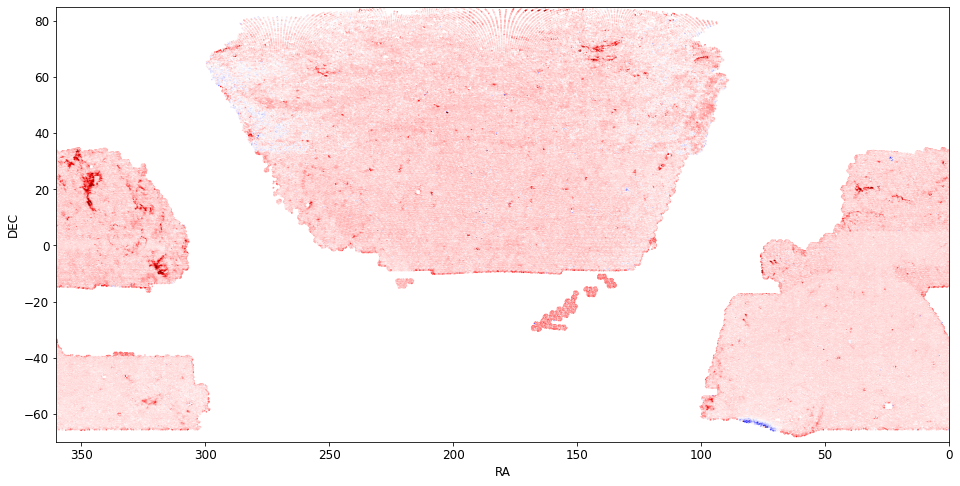

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(sky['RA'], sky['DEC'], '.', ms=0.2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'], sky['DEC'], c=sky['sky_median_g'], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

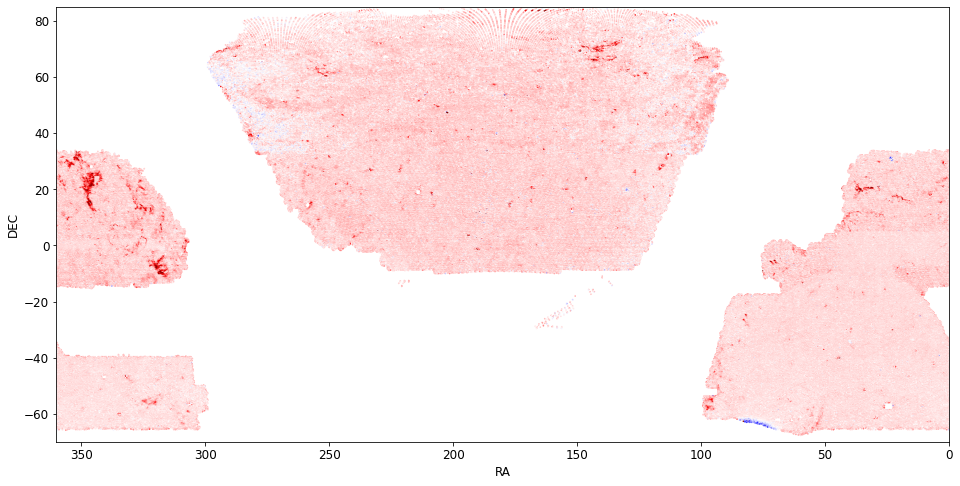

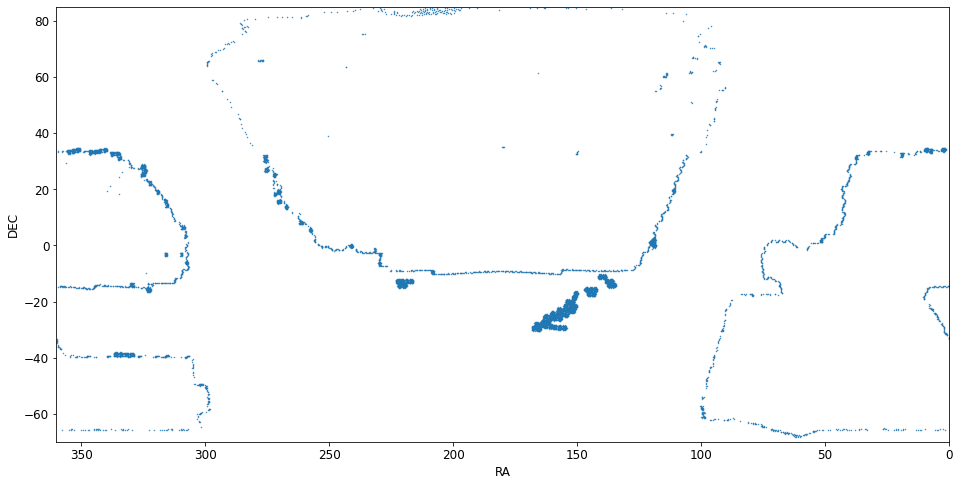

In [11]:
mask = (sky['NOBS_G']>1.5) & (sky['NOBS_R']>1.5) & (sky['NOBS_Z']>1.5)
plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'][mask], sky['DEC'][mask], c=sky['sky_median_g'][mask], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

mask = ~mask
plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'][mask], sky['DEC'][mask],s=0.2, vmin=-0.003, vmax=0.003)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [12]:
mask = (sky['NOBS_G']>1.5) & (sky['NOBS_R']>1.5) & (sky['NOBS_Z']>1.5)
sky = sky[mask]

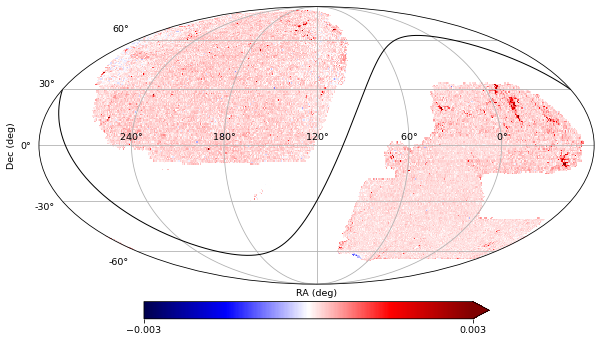

Done! 00:00:00


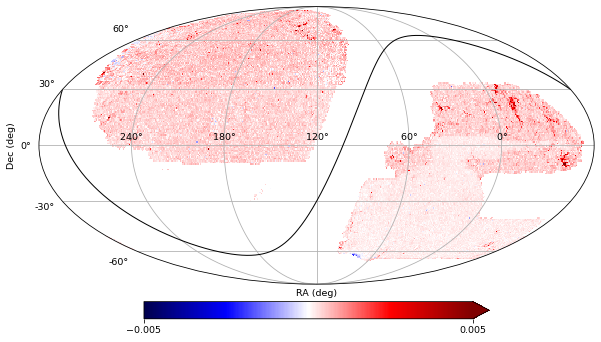

Done! 00:00:00


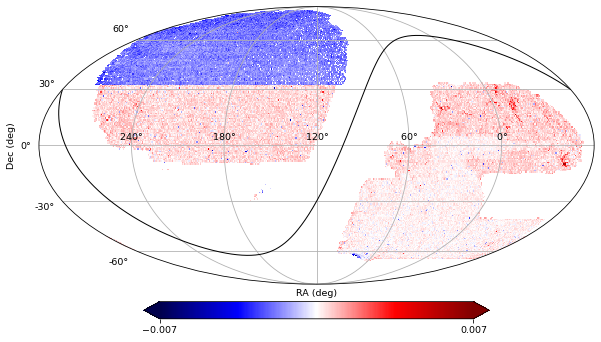

Done! 00:00:00


In [13]:
median_ranges = {'g':0.003, 'r':0.005, 'z':0.007}
for band in ['g', 'r', 'z']:
    plot_map(nside, sky['HPXPIXEL'], sky['sky_median_'+band],
             vmin=-median_ranges[band], vmax=median_ranges[band], cmap='seismic', nest=False,
             xsize=500, show=True)

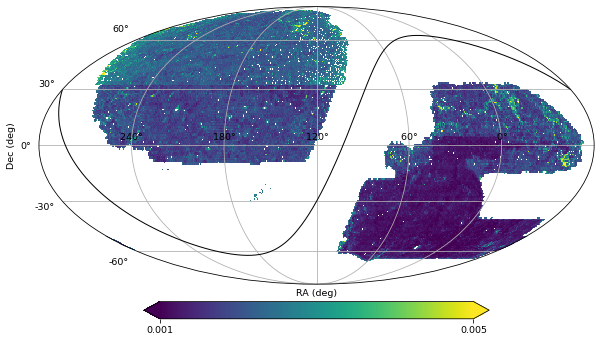

Done! 00:00:00


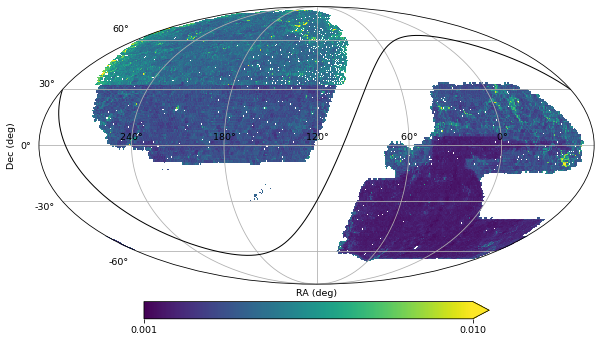

Done! 00:00:00


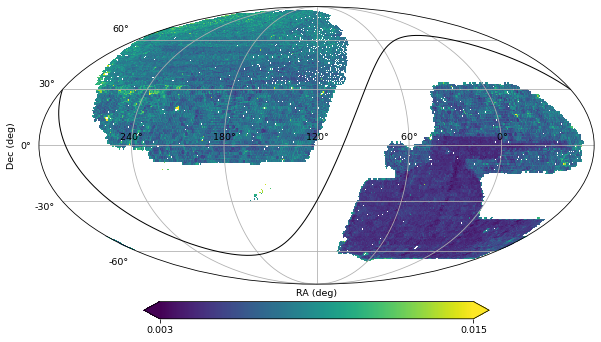

Done! 00:00:00


In [14]:
nmad_ranges = {'g':[0.001, 0.005], 'r':[0.001, 0.01], 'z':[0.003, 0.015]}
for band in ['g', 'r', 'z']:
    plot_map(nside, sky['HPXPIXEL'], sky['sky_nmad_'+band],
             vmin=nmad_ranges[band][0], vmax=nmad_ranges[band][1], cmap='viridis', nest=False,
             xsize=500, show=True)

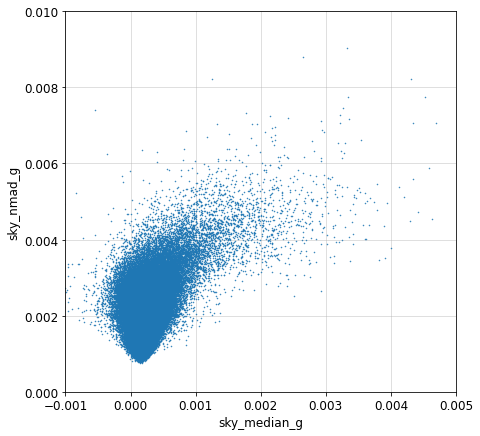

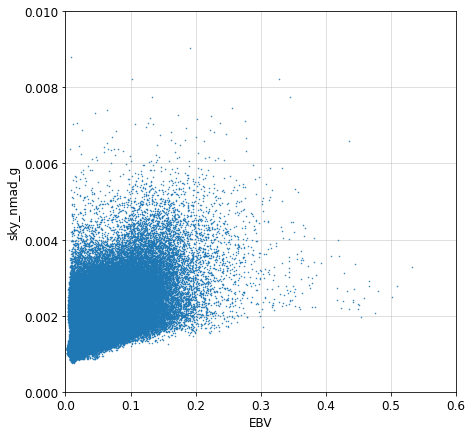

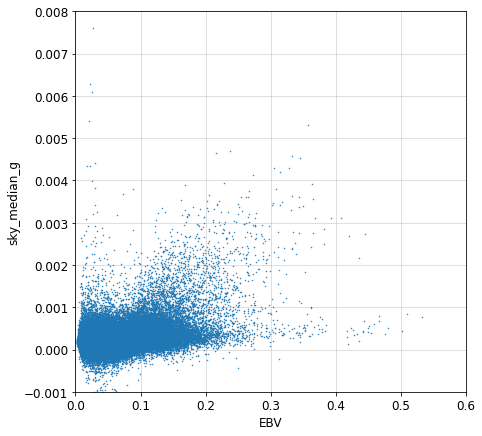

In [15]:
band = 'g'

plt.figure(figsize=(7, 7))
plt.plot(sky['sky_median_'+band], sky['sky_nmad_'+band], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([-0.001, 0.005, 0., 0.01])
plt.xlabel('sky_median_'+band)
plt.ylabel('sky_nmad_'+band)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'], sky['sky_nmad_'+band], '.', ms=1)
# mask = sky['PHOTSYS']=='S'
# plt.plot(sky['EBV'][mask], sky['sky_nmad_'+band][mask], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, 0., 0.01])
plt.xlabel('EBV')
plt.ylabel('sky_nmad_'+band)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'], sky['sky_median_'+band], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, -0.001, 0.008])
plt.xlabel('EBV')
plt.ylabel('sky_median_'+band)
plt.show()

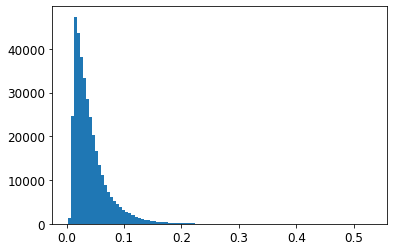

0.09936237454385896
0.05325394489094272


In [69]:
plt.hist(sky['EBV'], 100)
plt.show()

mask = sky['EBV']>0.08
print(np.sum(mask)/len(mask))

mask = sky['EBV']>0.1
print(np.sum(mask)/len(mask))

0.005570891398165994


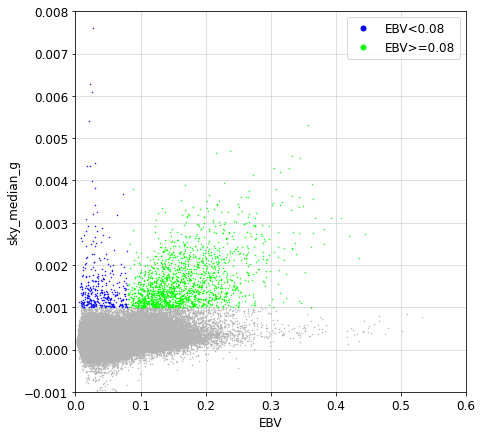

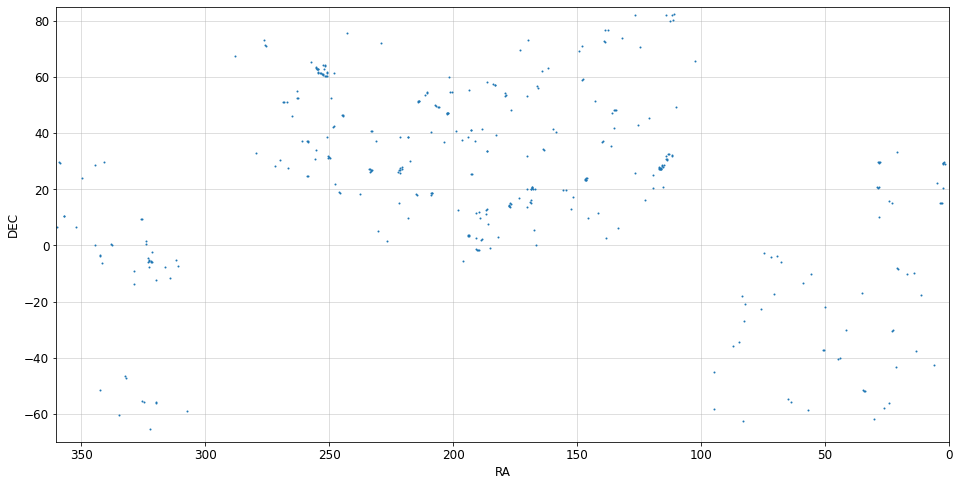

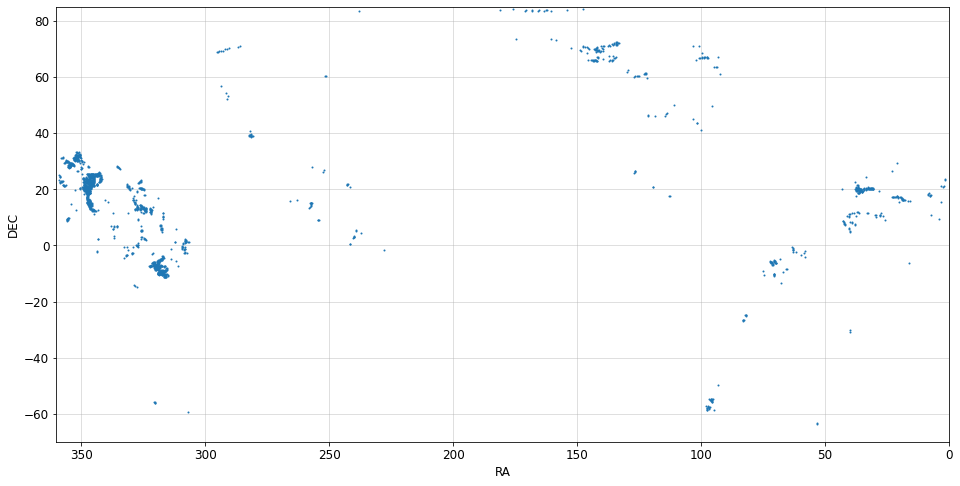

In [65]:
mask1 = (sky['EBV']<0.08) & (sky['sky_median_g']>0.001)
mask2 = (sky['EBV']>=0.08) & (sky['sky_median_g']>0.001)
mask0 = ~(mask1 | mask2)
print(np.sum(~mask0)/len(mask0))

band = 'g'
plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'][mask0], sky['sky_median_'+band][mask0], '.', c='0.7', ms=1)
plt.plot(sky['EBV'][mask1], sky['sky_median_'+band][mask1], '.', color='blue', ms=1, label='EBV<0.08')
plt.plot(sky['EBV'][mask2], sky['sky_median_'+band][mask2], '.', color='lime', ms=1, label='EBV>=0.08')
plt.grid(alpha=0.5)
plt.axis([0, 0.6, -0.001, 0.008])
plt.xlabel('EBV')
plt.ylabel('sky_median_'+band)
plt.legend(markerscale=10)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(sky['RA'][mask1], sky['DEC'][mask1], '.', ms=2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(sky['RA'][mask2], sky['DEC'][mask2], '.', ms=2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

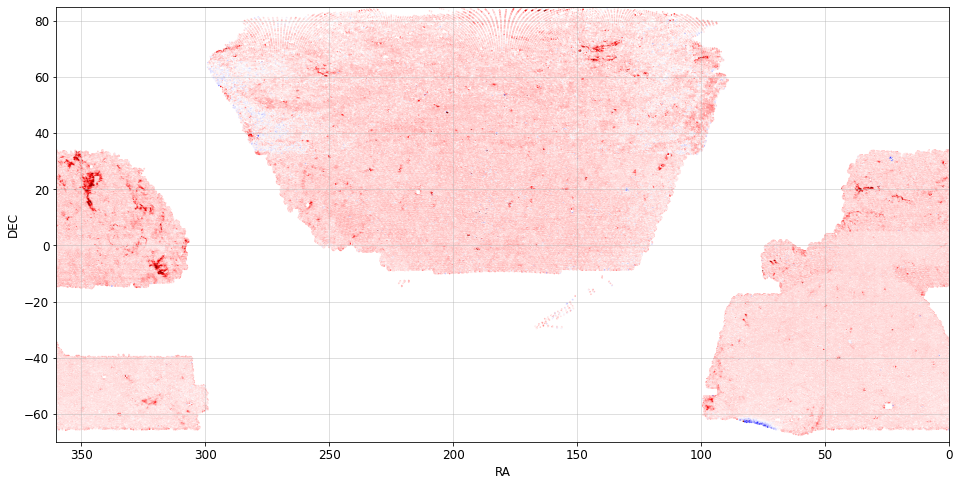

In [58]:
plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'], sky['DEC'], c=sky['sky_median_g'], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

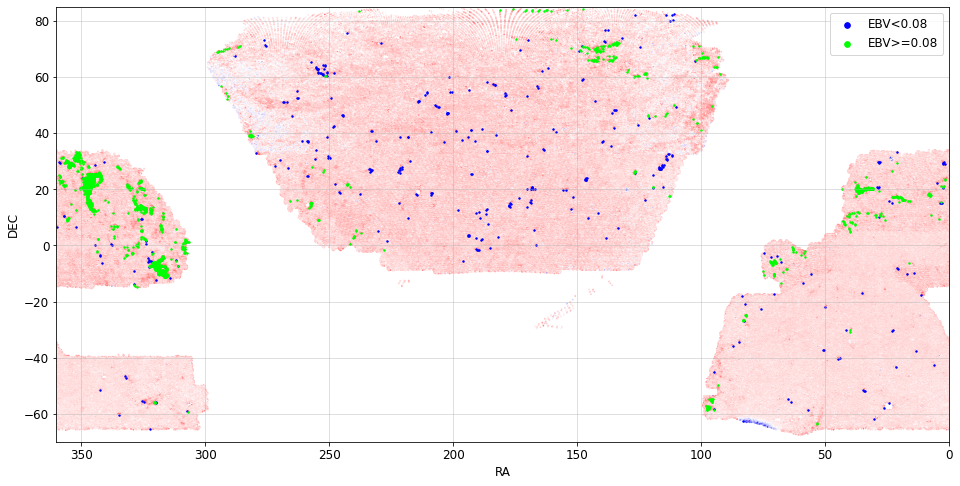

In [57]:
plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'][mask0], sky['DEC'][mask0], c=sky['sky_median_g'][mask0], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.scatter(sky['RA'][mask1], sky['DEC'][mask1], c='blue', s=2, label='EBV<0.08')
plt.scatter(sky['RA'][mask2], sky['DEC'][mask2], c='lime', s=2, label='EBV>=0.08')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.legend(markerscale=4)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

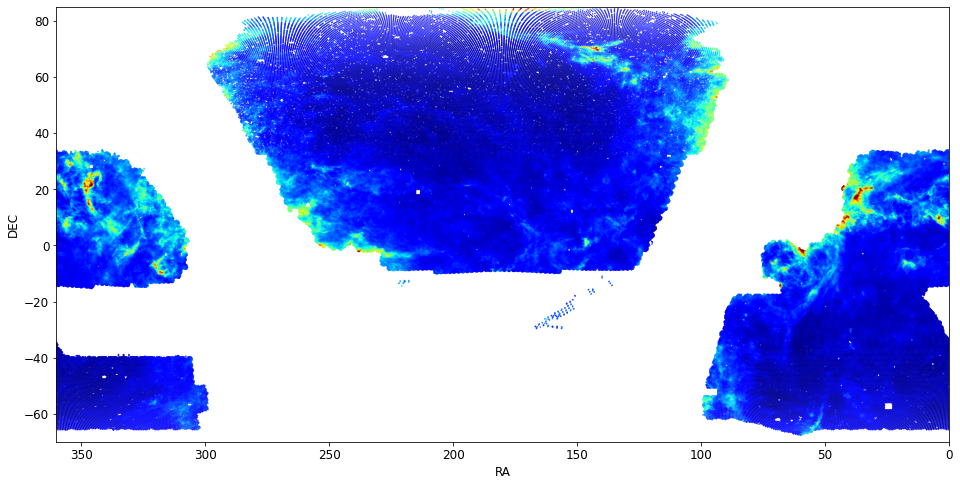

In [55]:
plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'], sky['DEC'], c=sky['EBV'], s=0.16, vmin=0, vmax=0.3, cmap='jet')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

-------

0.005459806823925396


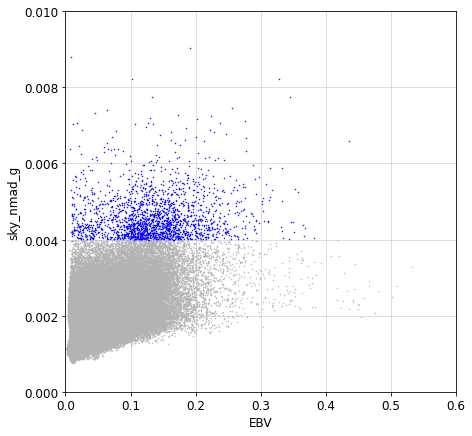

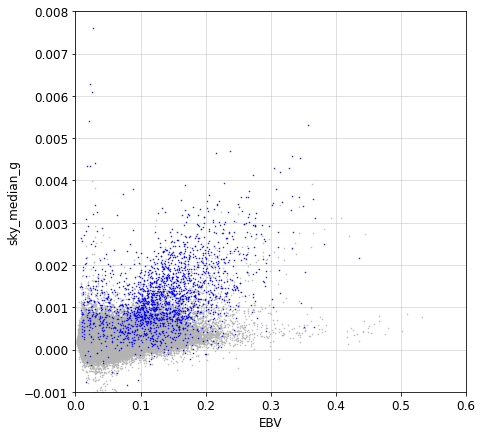

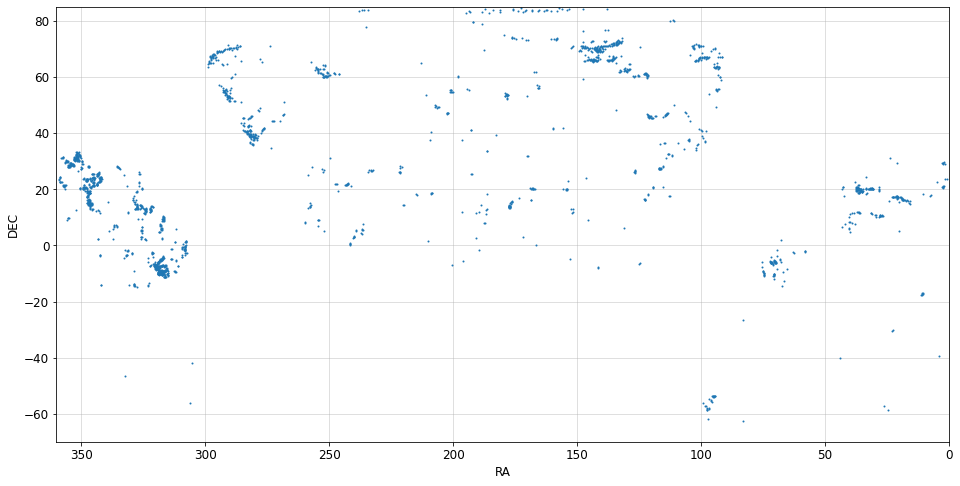

In [71]:
mask1 = sky['sky_nmad_g']>0.004
mask0 = ~mask1
print(np.sum(mask1)/len(mask1))

band = 'g'
plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'][mask0], sky['sky_nmad_'+band][mask0], '.', c='0.7', ms=1)
plt.plot(sky['EBV'][mask1], sky['sky_nmad_'+band][mask1], '.', color='blue', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, 0., 0.01])
plt.xlabel('EBV')
plt.ylabel('sky_nmad_'+band)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'][mask0], sky['sky_median_'+band][mask0], '.', c='0.7', ms=1)
plt.plot(sky['EBV'][mask1], sky['sky_median_'+band][mask1], '.', color='blue', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, -0.001, 0.008])
plt.xlabel('EBV')
plt.ylabel('sky_median_'+band)
# plt.legend(markerscale=10)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(sky['RA'][mask1], sky['DEC'][mask1], '.', ms=2)
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

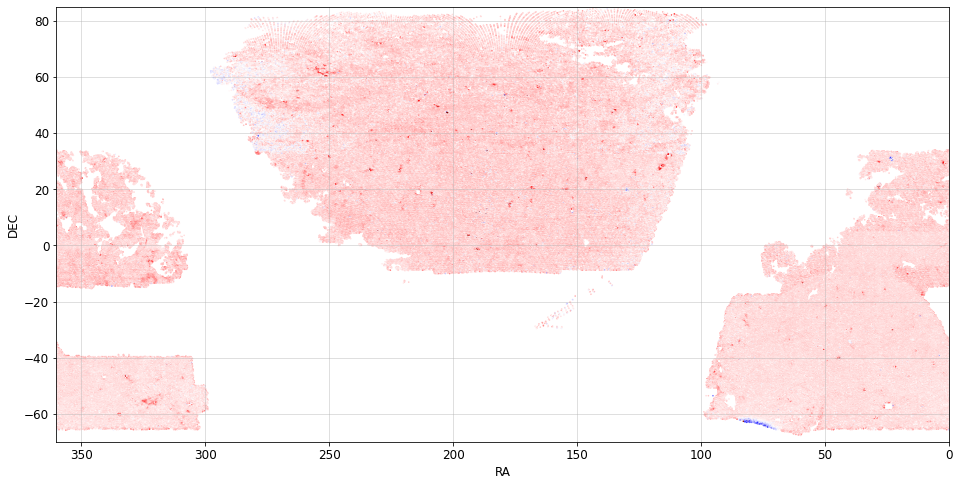

In [81]:
mask = sky['EBV']<0.08

plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'][mask], sky['DEC'][mask], c=sky['sky_median_g'][mask], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

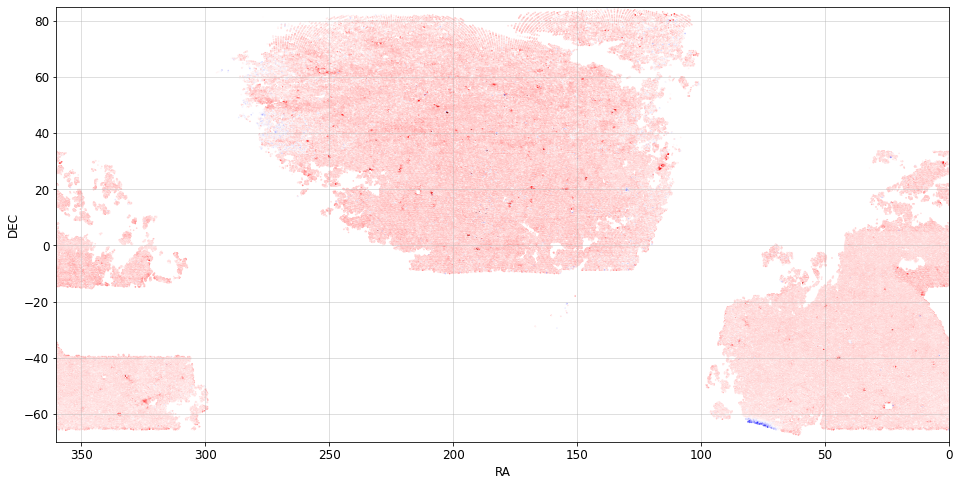

In [80]:
mask = sky['EBV']<0.05

plt.figure(figsize=(16, 8))
plt.scatter(sky['RA'][mask], sky['DEC'][mask], c=sky['sky_median_g'][mask], s=0.3, vmin=-0.003, vmax=0.003, cmap='seismic')
plt.gca().invert_xaxis()
plt.axis([360, 0, -70, 85])
plt.xlabel('RA')
plt.ylabel('DEC')
plt.grid(alpha=0.5)
plt.show()

----

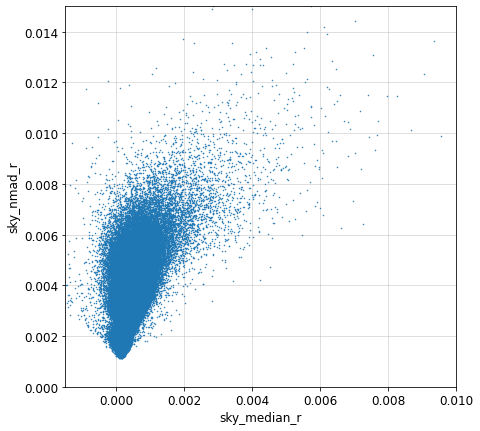

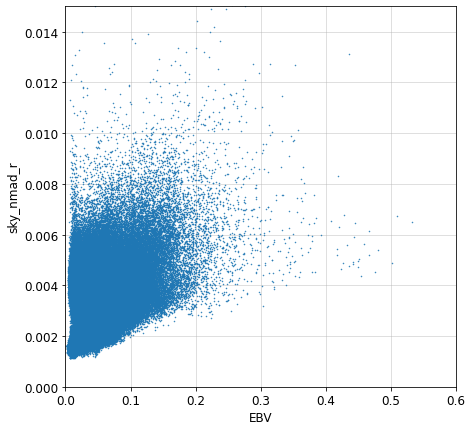

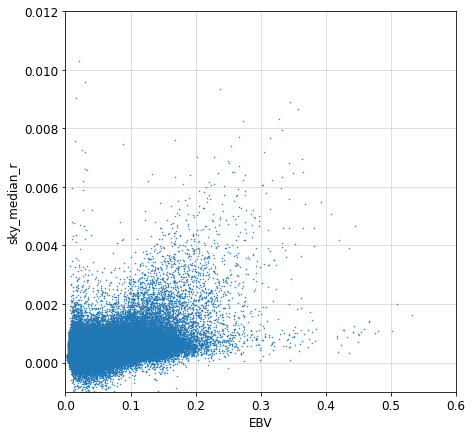

In [56]:
band = 'r'

plt.figure(figsize=(7, 7))
plt.plot(sky['sky_median_'+band], sky['sky_nmad_'+band], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([-0.0015, 0.01, 0., 0.015])
plt.xlabel('sky_median_'+band)
plt.ylabel('sky_nmad_'+band)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'], sky['sky_nmad_'+band], '.', ms=1)
# mask = sky['PHOTSYS']=='S'
# plt.plot(sky['EBV'][mask], sky['sky_nmad_'+band][mask], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, 0., 0.015])
plt.xlabel('EBV')
plt.ylabel('sky_nmad_'+band)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(sky['EBV'], sky['sky_median_'+band], '.', ms=1)
plt.grid(alpha=0.5)
plt.axis([0, 0.6, -0.001, 0.012])
plt.xlabel('EBV')
plt.ylabel('sky_median_'+band)
plt.show()